# Data Science - Laboratorio 4
## Redes neuronales convolucionales (CNN) 
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

## Librerias

NOTA: Importante tener el Token de la API en el folder `C:\Users\<Windows-username>\.kaggle\kaggle.json`

Para mas detalles de otros sistemas dirigirse a: https://github.com/Kaggle/kaggle-api/tree/main/docs#api-credentials

In [1]:
# Kaggle API
import kaggle
from kaggle.rest import ApiException

# Operaciones de archivos
import os
import zipfile
from glob import glob

# Operaciones de datos
import pandas as pd
import numpy as np
from PIL import Image

# Visualización
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## Carga de Dataset

In [2]:
# Nombre del dataset y rutas
dataset_name = 'agungpambudi/mnist-multiple-dataset-comprehensive-analysis'     # Nombre del dataset
download_path = 'mnist-multiple-dataset-comprehensive-analysis.zip'             # Ruta de descarga
target_dir = 'dataset'                                                            # Directorio de destino

# Verificar si ya existe el directorio de destino
if not os.path.exists(target_dir):
    # Autenticar con la API de Kaggle
    kaggle.api.authenticate()

    try:
        # Descargar el dataset de Kaggle si no existe
        if not os.path.exists(download_path):
            kaggle.api.dataset_download_files(dataset=dataset_name,
                                              quiet=False, 
                                              unzip=False)
            print(f"EXITO: Dataset descargado como '{download_path}'.\n")

    # Manejo de errores
    except ApiException as e:
        print("ERROR al llamar a KaggleApi -> datasets_download: %s\n" % e)

    try:
        # Descomprimir únicamente la carpeta MMNIST
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            members = [m for m in zip_ref.namelist() if m.startswith('PolyMNIST/MMNIST/')]
            
            # Barra de progreso para la descompresión
            for member in tqdm(members, desc="Descomprimiendo archivos", unit="archivo"):
                # Obtener el nombre del archivo relativo a MMNIST
                filename = os.path.relpath(member, 'PolyMNIST/MMNIST/')
                target_path = os.path.join(target_dir, filename)
                
                if not member.endswith('/'):
                    # Crear el directorio de destino si no existe
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    # Extraer el archivo
                    with zip_ref.open(member) as source, open(target_path, 'wb') as target:
                        target.write(source.read())

        # Eliminar el archivo ZIP después de la extracción
        os.remove(download_path)
        print(f"\nEXITO: Archivos de PolyMNIST descomprimidos en '{target_dir}'")

    except Exception as e:
        print("ERROR al descomprimir el dataset: %s\n" % e)

else:
    # Si ya existe el directorio, no hacer nada
    print(f"{target_dir} ya existe. Se omite la descarga y la extracción.")

dataset ya existe. Se omite la descarga y la extracción.


## Análisis Exploratorio

In [3]:
# Definir la ruta base del dataset
base_dir = "dataset"

# Obtener todas las imágenes del conjunto de datos
train_images = glob(os.path.join(base_dir, 'train', '**', '*.png'), recursive=True)
test_images = glob(os.path.join(base_dir, 'test', '**', '*.png'), recursive=True)

# Crear un DataFrame con la información de las imágenes
def create_dataframe(image_list):
    data = []
    for img in image_list:
        cont, digit = os.path.basename(img).split('.')[0:2]
        modality = img.split(os.sep)[-2]
        subset = img.split(os.sep)[-3]
        data.append([subset, modality, cont, digit, img])
    return pd.DataFrame(data, columns=['Subset', 'Modality', 'Cont', 'Digit', 'Path'])

train_df = create_dataframe(train_images)
test_df = create_dataframe(test_images)

# Mostrar las primeras filas del DataFrame de entrenamiento
train_df.head()

,Subset,Modality,Cont,Digit,Path
0,train,m0,0,0,dataset\train\m0\0.0.png
1,train,m0,0,1,dataset\train\m0\0.1.png
2,train,m0,0,2,dataset\train\m0\0.2.png
3,train,m0,0,3,dataset\train\m0\0.3.png
4,train,m0,0,4,dataset\train\m0\0.4.png


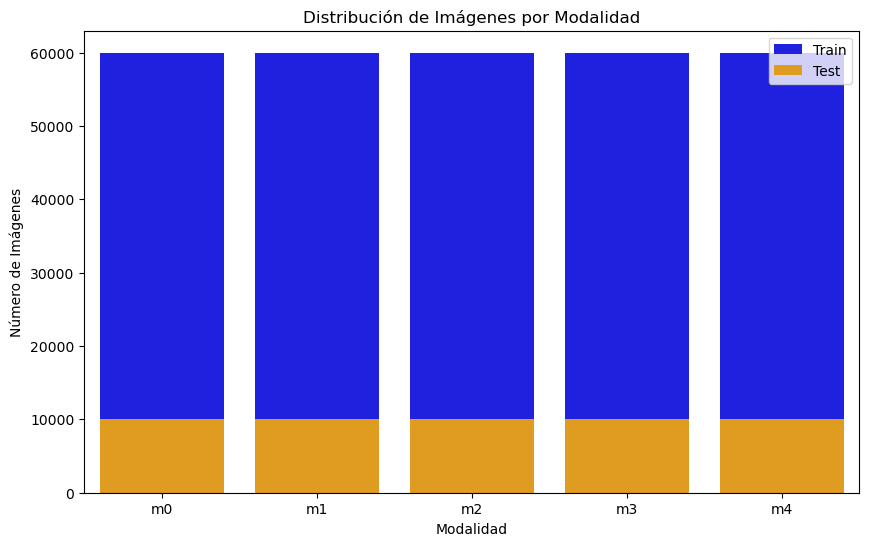

In [4]:
# Contar las imágenes por modalidad y subconjunto
modality_counts_train = train_df['Modality'].value_counts()
modality_counts_test = test_df['Modality'].value_counts()

# Visualizar la distribución por modalidad
plt.figure(figsize=(10, 6))
sns.barplot(x=modality_counts_train.index, y=modality_counts_train.values, color='blue', label='Train')
sns.barplot(x=modality_counts_test.index, y=modality_counts_test.values, color='orange', label='Test')
plt.title('Distribución de Imágenes por Modalidad')
plt.xlabel('Modalidad')
plt.ylabel('Número de Imágenes')
plt.legend()
plt.show()

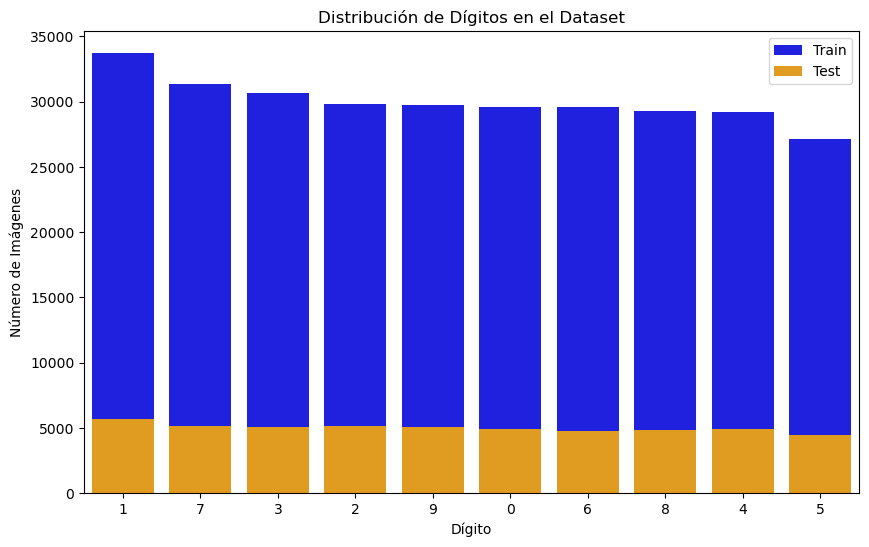

In [5]:
# Contar la distribución de dígitos
digit_counts_train = train_df['Digit'].value_counts()
digit_counts_test = test_df['Digit'].value_counts()

# Visualizar la distribución de dígitos
plt.figure(figsize=(10, 6))
sns.barplot(x=digit_counts_train.index, y=digit_counts_train.values, color='blue', label='Train')
sns.barplot(x=digit_counts_test.index, y=digit_counts_test.values, color='orange', label='Test')
plt.title('Distribución de Dígitos en el Dataset')
plt.xlabel('Dígito')
plt.ylabel('Número de Imágenes')
plt.legend()
plt.show()

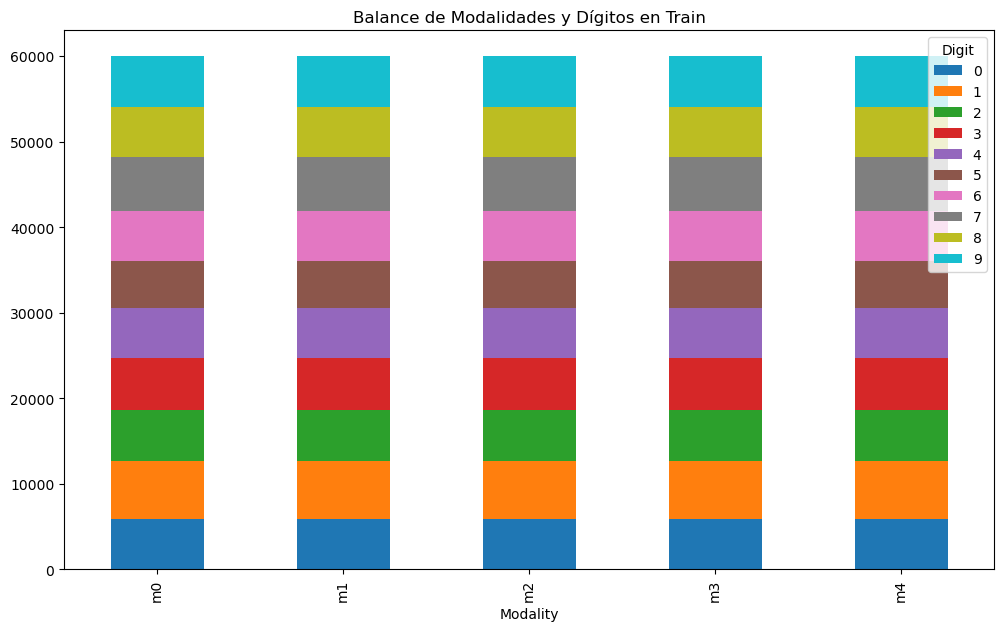

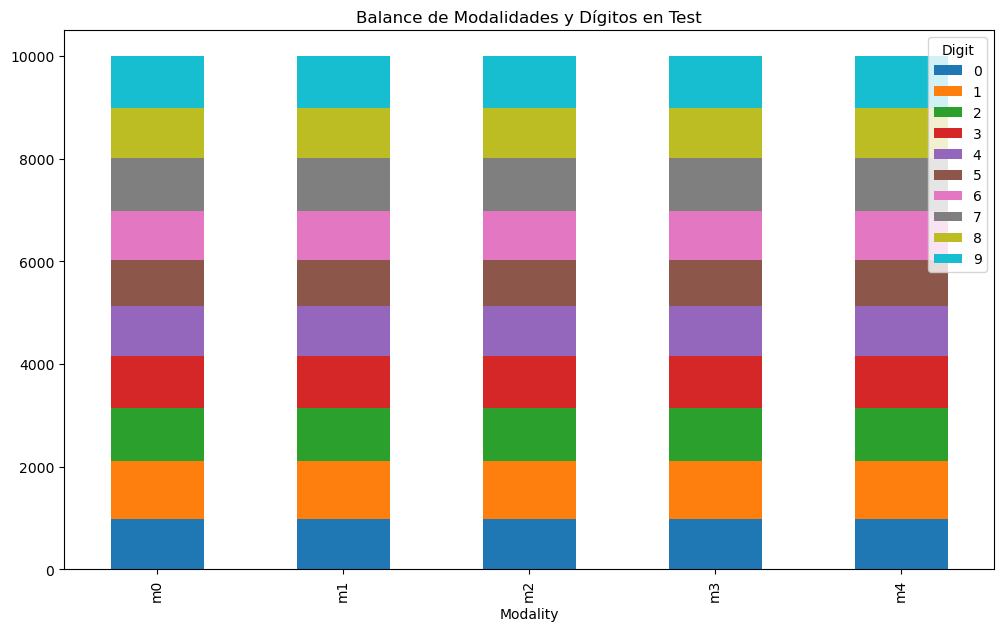

In [6]:
# Verificar el balance de los datos en términos de modalidad y dígito
balance_check_train = train_df.groupby(['Modality', 'Digit']).size().unstack(fill_value=0)
balance_check_test = test_df.groupby(['Modality', 'Digit']).size().unstack(fill_value=0)

# Mostrar la tabla de balance
balance_check_train.plot(kind='bar', stacked=True, figsize=(12, 7), title='Balance de Modalidades y Dígitos en Train')
plt.show()

balance_check_test.plot(kind='bar', stacked=True, figsize=(12, 7), title='Balance de Modalidades y Dígitos en Test')
plt.show()

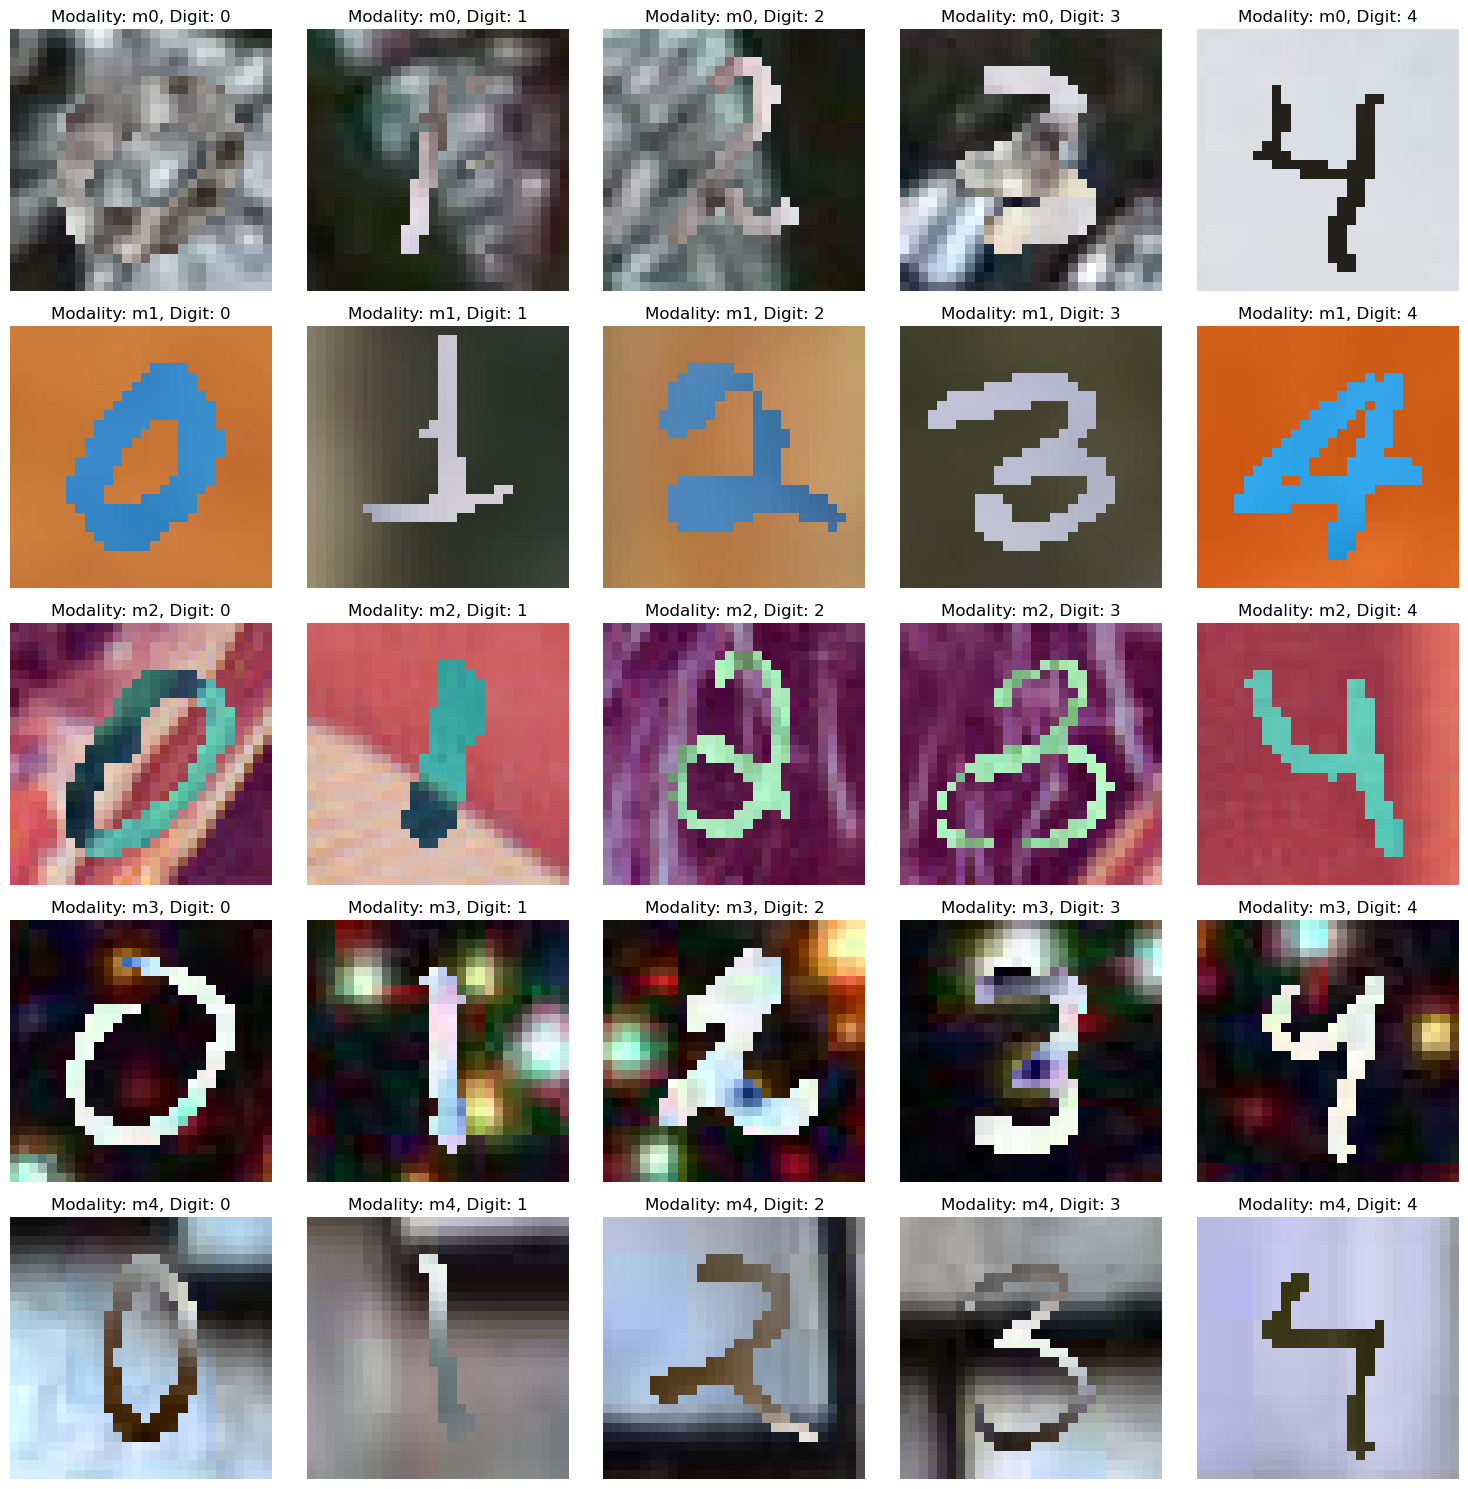

In [7]:
def plot_sample_images(df, modalities, digits, n=5):
    fig, axs = plt.subplots(len(modalities), n, figsize=(n*3, len(modalities)*3))
    
    for i, modality in enumerate(modalities):
        for j, digit in enumerate(digits[:n]):
            # Filtrar las filas que coinciden con la modalidad y el dígito
            filtered_df = df[(df['Modality'] == modality) & (df['Digit'] == str(digit))]
            
            if not filtered_df.empty:
                # Si hay al menos una fila, seleccionamos una muestra
                sample = filtered_df.sample(1)
                img = Image.open(sample['Path'].values[0])
                axs[i, j].imshow(np.array(img), cmap='gray')
                axs[i, j].axis('off')
                axs[i, j].set_title(f'Modality: {modality}, Digit: {digit}')
            else:
                # Si no hay imágenes, dejamos el subplot vacío
                axs[i, j].axis('off')
                axs[i, j].set_title(f'No image for\nModality: {modality}, Digit: {digit}')
    
    plt.tight_layout()
    plt.show()

# Mostrar imágenes de las 5 modalidades para los primeros 5 dígitos
plot_sample_images(train_df, modalities=['m0', 'm1', 'm2', 'm3', 'm4'], digits=range(5))
